In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

first we import data

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

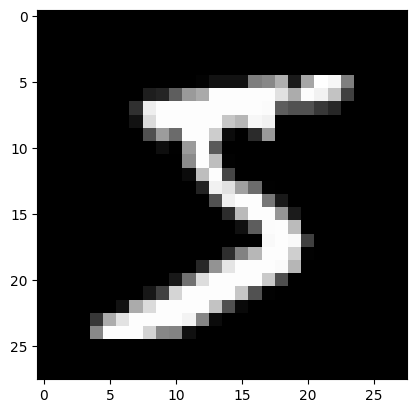

In [3]:
from matplotlib import pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28,28)),cmap="gray");

we tensorize the data

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor,(x_train,y_train,x_valid,y_valid))
print(x_train)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


next is what is really happening under the hood, but we can use library to skip them later

In [5]:
import math

weights = torch.randn(784,10) / math.sqrt(784) # don't want this step to be included in AD gradient
weights.requires_grad_() # "_" means operation is in-place, changes the variable "weights" when called
bias = torch.zeros(10,requires_grad=True)

here we create a simple single-layer affine + log_softmax model

In [6]:
# pick an activation function
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [7]:
bs = 64 #batch size for minibatch training

xb = x_train[0:bs] # get one batch of input
preds = model(xb)
print(preds[0], preds.shape) # each batch has 10 log probabilities for 10 digits

tensor([-2.5484, -2.3427, -2.1407, -1.7657, -2.6675, -2.1078, -2.4254, -2.7434,
        -2.4887, -2.2041], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [8]:
# loss function, input are log probabilities and gradient
def nll(input, target):
    # we sum up log(prob) corresponds to true label, the code is concise/clever but hard to read
    return -input[range(target.shape[0]),target].mean()

loss_func = nll

In [9]:
yb = y_train[0:bs] # get one batch of labels corresponding to input
print(range(yb.shape[0]))
preds[range(yb.shape[0]),yb]

range(0, 64)


tensor([-2.1078, -2.2548, -2.5276, -2.0229, -2.2252, -2.1209, -2.4186, -2.2712,
        -2.5314, -2.5612, -2.1270, -2.2342, -2.0451, -2.0375, -2.4564, -2.3785,
        -1.9116, -2.4607, -2.3018, -2.2024, -2.5667, -2.0223, -2.4537, -2.0826,
        -1.8899, -1.9175, -2.3537, -1.7718, -2.2452, -2.3208, -2.6205, -2.6174,
        -2.1256, -2.0782, -2.6785, -2.6931, -1.9740, -2.3840, -2.2604, -2.1087,
        -2.3586, -2.2124, -2.4355, -2.2794, -2.3290, -2.0717, -1.9455, -2.7669,
        -2.3024, -1.8568, -1.9997, -1.7667, -1.5548, -2.3398, -2.2064, -2.3405,
        -1.7075, -2.2743, -2.3784, -1.9612, -2.5605, -2.3746, -2.3792, -1.6029],
       grad_fn=<IndexBackward0>)

In [10]:
yb = y_train[0:bs]
print(loss_func(preds,yb))

tensor(2.2245, grad_fn=<NegBackward0>)


we can measure prediction accuracy for training or validation

In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out,dim=1)
    return (preds == yb).float().mean()

In [12]:
print(accuracy(preds, yb))
len(x_train)

tensor(0.1719)


50000

we start first draft of training, every step is explicitly shown

In [13]:
from IPython.core.debugger import set_trace # can ignore this, for easy debugging purpose
lr = 0.5
epochs = 2
n = len(x_train) # total sample size
for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        preds = model(xb)
        loss = loss_func(preds,yb)

        loss.backward()
        # dont want to record this action for gradient, put under with context
        with torch.no_grad():
            # gradient descent
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

> c:\users\bryan\appdata\local\temp\ipykernel_21708\2097258380.py(8)<module>()



In [13]:
print(loss_func(model(xb),yb),accuracy(model(xb),yb))

tensor(2.2245, grad_fn=<NegBackward0>) tensor(0.1719)


We can simplify the code a lot via library. First, we use nn.functional to get common loss functions

In [14]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias
# notice we only need a single-layer affine model, cross_entropy takes care of the log_softmax activation

In [15]:
print(loss_func(model(xb),yb),accuracy(model(xb),yb))

tensor(2.2245, grad_fn=<NllLossBackward0>) tensor(0.1719)


nn.Parameter to set up weights and biases easily in the model class

In [16]:
from torch import nn
import math

# nn.Module objects are callable ie they are functions, and this will call forward automatically
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__() #init the super class nn.Module, so our new class has all the objects associated with the super class
        self.weights = nn.Parameter(torch.randn(784,10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    # pass input forward, model is affine so we just apply that
    def forward(self,xb):
        return xb @ self.weights + self.bias
        

In [17]:
model = Mnist_Logistic()

In [18]:
print(loss_func(model(xb),yb)) # model directly calls forward with xb as input

tensor(2.4407, grad_fn=<NllLossBackward0>)


In [19]:
lr = 0.5 # learn rate (step size for SGD)
epochs = 2 # how many times do we train over the whole dataset
n = len(x_train) # total sample size
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred,yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): 
                    p -= p.grad * lr
                model.zero_grad()

#fit()

In [20]:
print(loss_func(model(xb),yb))

tensor(2.4407, grad_fn=<NllLossBackward0>)


using nn.Linear to set up weights and bias in one line

In [21]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784,10) # handle the weights and bias
    
    def forward(self,xb):
        return self.lin(xb) 
    

In [22]:
model = Mnist_Logistic()
print(loss_func(model(xb),yb))

tensor(2.2997, grad_fn=<NllLossBackward0>)


In [23]:
fit()
print(loss_func(model(xb),yb))

tensor(0.2295, grad_fn=<NllLossBackward0>)


using optim to replace "with torch.no_grad()" with "opt.step() and opt.zero_grad()"

In [24]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr = lr) # SGD needs the parameters (weights and bias) and lr to set up

model, opt = get_model()

In [25]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        pred = model(xb)
        loss = loss_func(pred,yb)

        loss.backward()
        # opt allows skipping with no_grad
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb),yb))

tensor(0.0805, grad_fn=<NllLossBackward0>)


using TensorDataset to index data in bulk

In [26]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train,y_train)

In [27]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb, yb = train_ds[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred,yb)

        loss.backward()
        # opt allows skipping with no_grad
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb),yb))

tensor(0.0649, grad_fn=<NllLossBackward0>)


DataLoader to simplify iterating over batches

In [28]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=bs)

In [29]:
for epoch in range(epochs):
    for xb,yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred,yb)

        loss.backward()
        # opt allows skipping with no_grad
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb),yb))

tensor(0.0595, grad_fn=<NllLossBackward0>)


Add validation

In [30]:
train_ds = TensorDataset(x_train,y_train)
train_dl = DataLoader(train_ds,batch_size=bs,shuffle=True)
valid_ds = TensorDataset(x_valid,y_valid)
valid_dl = DataLoader(valid_ds,batch_size=bs*2) # validation takes less memory, can do large batch, no need to shuffle since not learning correlation

In [31]:
model, opt = get_model()

for epoch in range(epochs):
    model.train() # just a safeguard for other accessory functions
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred,yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval() # just a safeguard for other accessory functions
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb),yb) for xb,yb in valid_dl)
    
    print(epoch, valid_loss/len(valid_dl))

0 tensor(0.3198)
1 tensor(0.4444)


consolidate similar process of computing loss

In [32]:
def loss_batch(model,loss_func,xb,yb,opt = None):
    loss  = loss_func(model(xb),yb)

    if opt is not None: # this gives two use cases: 1. just compute loss; 2. back propagate and update as well
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [33]:
import numpy as np
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss_batch(model,loss_func,xb,yb,opt)
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model,loss_func,xb,yb) for xb,yb in valid_dl] #no opt input so it only computes loss without update
                  )
                # The result of the list comprehension is a list of tuples. Each tuple contains two elements: the loss and the batch size.
                # The * operator is used to unpack this list of tuples so that zip can process it correctly.
                # zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]) effectively transposes this list of tuples. 
                # This means that all the first elements (losses) are grouped together, and all the second elements (batch sizes) are grouped together.
            val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums) # weight losses by batch sizes and normalize, batch size should be 2*bs for most but not for all
        print(epoch,val_loss)

In [34]:

def get_data(train_ds,valid_ds,bs):
    return ( DataLoader(train_ds, batch_size=bs, shuffle=True), 
             DataLoader(valid_ds, batch_size=bs*2) )

In [35]:
train_dl, valid_dl = get_data(train_ds,valid_ds,bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33498039371967314
1 0.3533739457130432


let us try this on a CNN. First we build it the silly/tedious way similar to our previous model:

In [36]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28) # view is reshape in MATLAB, -1 is placeholder inferred from other dims, ???? WHY 4D shape instead of 3D shape TODO
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1)) # vectorize the data back

lr = 0.1

In [37]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9) # momentum for better performance
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4543928606033325
1 0.23208876793384553


It would be easier to build the network sequentially layer by layer. We use nn.Sequential, but we want to setup custom layer that isn't supported by Pytorch. To do that we use a Lambda class:

In [38]:
class Lambda(nn.Module):
    def __init__(self, func): # the class Lambda takes a function as input
        super().__init__()
        self.func = func
    def forward(self, x): # usage: self.forward(x) to get func(x) as output
        return self.func(x)

def preprocess(x):
    return x.view([-1, 1, 28, 28]) 

In [39]:
model = nn.Sequential(
    Lambda(preprocess),  # now we have a "preprocess" or "view" custom layer to reshape data
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # input channels, output channels, kernel is 3x3 pixels (local features) 
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), # stride is 2 pixels move per step for convolution, =1 same size output as input, =2 downsampling
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1), # pads 1 pixel around image to learn edge features, = (kernel_size - 1) mod 2,  
    nn.ReLU(),
    nn.AvgPool2d(4), # smoothing and dimension reducing over 4x4 kernel
    Lambda(lambda x: x.view(x.size(0),-1)) # vectorize layer, can also do this for preprocess layer using lambda function
)
opt = optim.SGD(model.parameters(), lr = lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3951185884714127
1 0.2185700836777687


generalize the model to work for 2D image of any size, use WrappedDataLoader to reshape into any size

In [40]:
def preprocess(x, y):
    return x.view([-1, 1, 28, 28]), y

class WrappedDataLoader(nn.Module):
    def __init__(self, dl, func):
        super().__init__()
        self.dl = dl
        self.func = func

    def __len__(self, dl):
        return len(self.dl)
    def __iter__(self):
        for b in self.dl:
            yield self.func(*b) # unpack b which is data and labels
            # yield is used here to make a generator, which is more memory-efficient than a function since the value is returned on the fly and not stored in a big list to return

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [41]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1), # adaptive to shape so output size is 1
    Lambda(lambda x: x.view(x.size(0),-1)) # vectorize layer, can also do this for preprocess layer using lambda function    
)
opt = optim.SGD(model.parameters(), lr = lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4104154346227646
1 0.24352723976373672


Add GPU

In [42]:
print(torch.cuda.is_available())

True
